In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from sklearn import preprocessing
import os
import seaborn as sns
sns.set(style="darkgrid")
from skimage.feature import hog
from scipy.cluster.vq import kmeans,vq
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import matthews_corrcoef,make_scorer,f1_score

### Separating files for training and testing

In [2]:
feature_files_path="./features/"
files=[os.path.join(feature_files_path,file) for file in os.listdir(feature_files_path)]

In [3]:
training_files = ["-nm-01-","-nm-02-","-nm-03-","-nm-04-"]
training_set_files = [file for file in files if any(training_file in file for training_file in training_files)]

In [4]:
test_1_files = ["-nm-05-","-nm-06-"]
test_set_1_files = [file for file in files if any(training_file in file for training_file in test_1_files)]

In [5]:
test_2_files = ["-bg-01-","-bg-02-"]
test_set_2_files = [file for file in files if any(training_file in file for training_file in test_2_files)]

In [6]:
test_3_files = ["-cl-01-","-cl-02-"]
test_set_3_files = [file for file in files if any(training_file in file for training_file in test_3_files)]

## Encoding for training data

In [7]:
hog_codebook = pd.read_csv('hog_codebook.csv')
hog_codebook = hog_codebook.drop(hog_codebook.columns[0],axis=1)
mbhx_codebook = pd.read_csv('mbhx_codebook.csv')
mbhx_codebook = mbhx_codebook.drop(mbhx_codebook.columns[0],axis=1)
mbhy_codebook = pd.read_csv('mbhy_codebook.csv')
mbhy_codebook = mbhy_codebook.drop(mbhy_codebook.columns[0],axis=1)

In [8]:
print("Hog CodeBook Shape",hog_codebook.shape)
print("MBHX CodeBook Shape",mbhx_codebook.shape)
print("MBHY CodeBook Shape",mbhy_codebook.shape)

Hog CodeBook Shape (256, 96)
MBHX CodeBook Shape (256, 96)
MBHY CodeBook Shape (256, 96)


### Histogram of training Images using Vector Encoding

In [9]:
k = 256
trajectory_range = 40
hog_range = trajectory_range+96
hof_range = hog_range+108
mbhx_range = hof_range+96
mbhy_range = mbhx_range+96

In [10]:
hog = []
mbhx = []
mbhy = []
for file in training_set_files:
    
    features = pd.read_csv(file,'\t',header=None)
    features.drop(features.columns[-1],axis=1,inplace=True)
    
    hog.append((file,features.iloc[:,trajectory_range:hog_range]))
    mbhx.append((file,features.iloc[:,hof_range:mbhx_range]))
    mbhy.append((file,features.iloc[:,mbhx_range:mbhy_range]))

In [11]:
hog_hist = np.zeros((len(training_set_files),k),"float32")
for i in range(len(training_set_files)):
    words,distance=vq(hog[i][1],hog_codebook)
    for w in words:
        hog_hist[i][w]+=1

In [12]:
mbhx_hist = np.zeros((len(training_set_files),k),"float32")
for i in range(len(training_set_files)):
    words,distance=vq(mbhx[i][1],mbhx_codebook)
    for w in words:
        mbhx_hist[i][w]+=1

In [13]:
mbhy_hist = np.zeros((len(training_set_files),k),"float32")
for i in range(len(training_set_files)):
    words,distance=vq(mbhy[i][1],mbhy_codebook)
    for w in words:
        mbhy_hist[i][w]+=1

In [14]:
pd.DataFrame(mbhy_hist)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,12.0,19.0,39.0,11.0,12.0,24.0,12.0,46.0,26.0,13.0,...,19.0,50.0,13.0,15.0,136.0,15.0,13.0,27.0,19.0,17.0
1,23.0,21.0,27.0,9.0,11.0,9.0,22.0,46.0,35.0,27.0,...,14.0,39.0,16.0,26.0,73.0,15.0,18.0,38.0,22.0,21.0
2,10.0,7.0,49.0,14.0,12.0,21.0,14.0,27.0,30.0,21.0,...,27.0,45.0,33.0,13.0,95.0,18.0,14.0,43.0,27.0,12.0
3,8.0,10.0,45.0,26.0,14.0,23.0,14.0,40.0,16.0,24.0,...,16.0,42.0,32.0,5.0,83.0,34.0,5.0,24.0,20.0,13.0
4,15.0,31.0,43.0,6.0,9.0,26.0,15.0,20.0,39.0,24.0,...,20.0,35.0,20.0,9.0,7.0,23.0,35.0,11.0,21.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,14.0,34.0,54.0,6.0,16.0,13.0,21.0,25.0,38.0,49.0,...,24.0,24.0,23.0,27.0,88.0,21.0,12.0,30.0,14.0,23.0
492,26.0,29.0,36.0,12.0,15.0,13.0,27.0,26.0,34.0,28.0,...,18.0,33.0,26.0,40.0,118.0,36.0,22.0,17.0,13.0,13.0
493,23.0,22.0,36.0,9.0,8.0,6.0,14.0,23.0,24.0,29.0,...,21.0,27.0,21.0,31.0,130.0,30.0,8.0,19.0,16.0,21.0
494,24.0,30.0,35.0,22.0,15.0,14.0,15.0,13.0,33.0,37.0,...,24.0,25.0,10.0,13.0,159.0,29.0,14.0,9.0,21.0,12.0


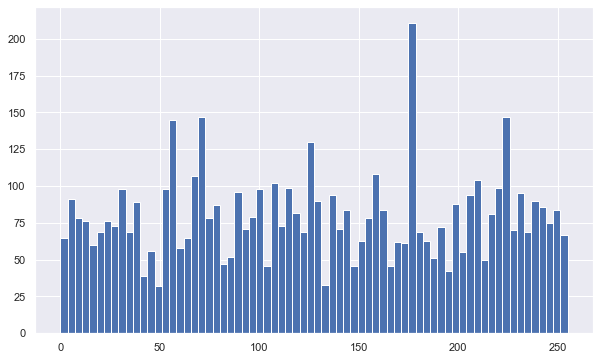

In [15]:
plt.figure(figsize=(10,6))
x = range(len(hog_hist[0]))
y = hog_hist[0]
plt.hist(x, weights=y, bins=70);

# Feature Fusion

In [16]:
features = np.concatenate((hog_hist, mbhx_hist,mbhy_hist), axis=1)

In [17]:
np.savetxt("features.csv", features, delimiter=",")

# Classification

In [18]:
features = pd.read_csv("features.csv",header=None)

In [19]:
labels = []
for file in training_set_files:
    labels.append(file.split('/')[2].split('-')[0])

In [20]:
features['label']=labels

In [21]:
features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,22.0,24.0,10.0,9.0,29.0,31.0,21.0,10.0,18.0,50.0,...,50.0,13.0,15.0,136.0,15.0,13.0,27.0,19.0,17.0,1
1,21.0,36.0,12.0,12.0,14.0,31.0,41.0,27.0,21.0,30.0,...,39.0,16.0,26.0,73.0,15.0,18.0,38.0,22.0,21.0,1
2,20.0,35.0,11.0,10.0,10.0,40.0,35.0,14.0,25.0,30.0,...,45.0,33.0,13.0,95.0,18.0,14.0,43.0,27.0,12.0,1
3,23.0,34.0,7.0,13.0,8.0,34.0,29.0,23.0,30.0,28.0,...,42.0,32.0,5.0,83.0,34.0,5.0,24.0,20.0,13.0,1
4,21.0,34.0,17.0,60.0,44.0,27.0,22.0,26.0,28.0,24.0,...,35.0,20.0,9.0,7.0,23.0,35.0,11.0,21.0,26.0,10


In [24]:
X.shape

(496, 768)

In [29]:
from sklearn.svm import LinearSVC
model = LinearSVC()
X = features.iloc[:,:-1]
y = features.iloc[:,-1]
model.fit(X, y)

LinearSVC()

In [9]:
pickle.dump(model, open("SVM_Model", 'wb'))

NameError: name 'model' is not defined

# Model Inference

In [10]:
#load model
model = pickle.load(open("SVM_Model", 'rb'))

In [11]:
def print_score(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='weighted')
    recall = metrics.recall_score(y_test, y_pred,average='weighted')
    f1score = metrics.f1_score(y_test, y_pred,average='weighted')    
    print("Accuracy :",accuracy)
    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", f1score)
    
    #print CM
    matrix_logit = confusion_matrix(y_test, y_pred)
    print(matrix_logit)
    
    return accuracy, precision, recall, f1score

# Test 1

In [14]:
hog_test = []
mbhx_test = []
mbhy_test = []
for file in test_set_1_files:
    
    features_test = pd.read_csv(file,'\t',header=None)
    features_test.drop(features_test.columns[-1],axis=1,inplace=True)
    
    hog_test.append((file,features_test.iloc[:,trajectory_range:hog_range]))
    mbhx_test.append((file,features_test.iloc[:,hof_range:mbhx_range]))
    mbhy_test.append((file,features_test.iloc[:,mbhx_range:mbhy_range]))

In [15]:
hog_hist_test = np.zeros((len(test_set_1_files),k),"float32")
for i in range(len(test_set_1_files)):
    words,distance=vq(hog_test[i][1],hog_codebook)
    for w in words:
        hog_hist_test[i][w]+=1

In [16]:
mbhx_hist_test = np.zeros((len(test_set_1_files),k),"float32")
for i in range(len(test_set_1_files)):
    words,distance=vq(mbhx_test[i][1],mbhx_codebook)
    for w in words:
        mbhx_hist_test[i][w]+=1

In [17]:
mbhy_hist_test = np.zeros((len(test_set_1_files),k),"float32")
for i in range(len(test_set_1_files)):
    words,distance=vq(mbhy_test[i][1],mbhy_codebook)
    for w in words:
        mbhy_hist_test[i][w]+=1

In [18]:
hog_hist_test.shape

(248, 256)

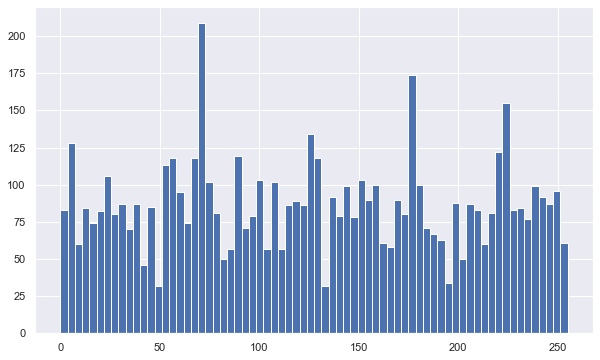

In [19]:
plt.figure(figsize=(10,6))
x = range(len(hog_hist_test[0]))
y = hog_hist_test[0]
plt.hist(x, weights=y, bins=70);

# Feature Fusion

In [20]:
test_features = np.concatenate((hog_hist_test, mbhx_hist_test,mbhy_hist_test), axis=1)

In [21]:
np.savetxt("test_1_features.csv", test_features, delimiter=",")

In [22]:
test_features = pd.read_csv("test_1_features.csv",header=None)

In [23]:
labels = []
for file in test_set_1_files:
    labels.append(file.split('/')[2].split('-')[0])

In [24]:
test_features['label']=labels

In [25]:
X_test1 = test_features.iloc[:,:-1]
y_test1 = test_features.iloc[:,-1]

y_pred = model.predict(X_test1)
print_score(y_test1,y_pred);

Accuracy : 1.0
Precision : 1.0
Recall : 1.0
F1 Score : 1.0
[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


# Test 2

In [11]:
hog_test2 = []
mbhx_test2 = []
mbhy_test2 = []
for file in test_set_2_files:
    
    features_test2 = pd.read_csv(file,'\t',header=None)
    features_test2.drop(features_test2.columns[-1],axis=1,inplace=True)
    
    hog_test2.append((file,features_test2.iloc[:,trajectory_range:hog_range]))
    mbhx_test2.append((file,features_test2.iloc[:,hof_range:mbhx_range]))
    mbhy_test2.append((file,features_test2.iloc[:,mbhx_range:mbhy_range]))

In [12]:
hog_hist_test2 = np.zeros((len(test_set_2_files),k),"float32")
for i in range(len(test_set_2_files)):
    words,distance=vq(hog_test2[i][1],hog_codebook)
    for w in words:
        hog_hist_test2[i][w]+=1

In [13]:
mbhx_hist_test2 = np.zeros((len(test_set_2_files),k),"float32")
for i in range(len(test_set_2_files)):
    words,distance=vq(mbhx_test2[i][1],mbhx_codebook)
    for w in words:
        mbhx_hist_test2[i][w]+=1

In [14]:
mbhy_hist_test2 = np.zeros((len(test_set_2_files),k),"float32")
for i in range(len(test_set_2_files)):
    words,distance=vq(mbhy_test2[i][1],mbhy_codebook)
    for w in words:
        mbhy_hist_test2[i][w]+=1

In [15]:
hog_hist_test2.shape

(248, 256)

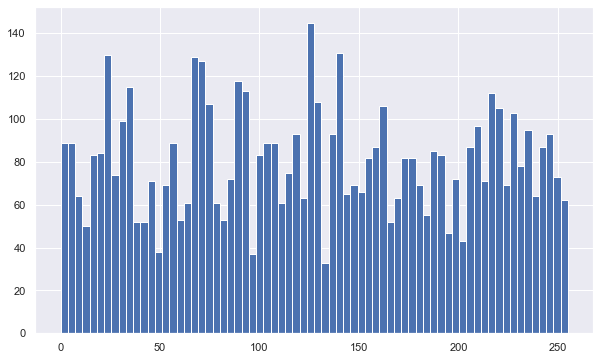

In [16]:
plt.figure(figsize=(10,6))
x = range(len(hog_hist_test2[0]))
y = hog_hist_test2[0]
plt.hist(x, weights=y, bins=70);

# Feature Fusion

In [17]:
test_features2 = np.concatenate((hog_hist_test2, mbhx_hist_test2, mbhy_hist_test2), axis=1)

In [18]:
np.savetxt("test_2_features.csv", test_features2, delimiter=",")

In [19]:
test_features2 = pd.read_csv("test_2_features.csv",header=None)

In [20]:
labels = []
for file in test_set_2_files:
    labels.append(file.split('/')[2].split('-')[0])

In [21]:
test_features2['label']=labels

In [24]:
X_test2 = test_features2.iloc[:,:-1]
y_test2 = test_features2.iloc[:,-1]

y_pred2 = model.predict(X_test2)
print_score(y_test2,y_pred2);

Accuracy : 0.8306451612903226
Precision : 0.8101254480286738
Recall : 0.8306451612903226
F1 Score : 0.7997451473257925
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]


# Test 3

In [12]:
hog_test3 = []
mbhx_test3 = []
mbhy_test3 = []
for file in test_set_3_files:
    
    features_test3 = pd.read_csv(file,'\t',header=None)
    features_test3.drop(features_test3.columns[-1],axis=1,inplace=True)
    
    hog_test3.append((file,features_test3.iloc[:,trajectory_range:hog_range]))
    mbhx_test3.append((file,features_test3.iloc[:,hof_range:mbhx_range]))
    mbhy_test3.append((file,features_test3.iloc[:,mbhx_range:mbhy_range]))

In [13]:
hog_hist_test3 = np.zeros((len(test_set_3_files),k),"float32")
for i in range(len(test_set_3_files)):
    words,distance=vq(hog_test3[i][1],hog_codebook)
    for w in words:
        hog_hist_test3[i][w]+=1

In [14]:
mbhx_hist_test3 = np.zeros((len(test_set_3_files),k),"float32")
for i in range(len(test_set_3_files)):
    words,distance=vq(mbhx_test3[i][1],mbhx_codebook)
    for w in words:
        mbhx_hist_test3[i][w]+=1

In [15]:
mbhy_hist_test3 = np.zeros((len(test_set_3_files),k),"float32")
for i in range(len(test_set_3_files)):
    words,distance=vq(mbhy_test3[i][1],mbhy_codebook)
    for w in words:
        mbhy_hist_test3[i][w]+=1

In [16]:
hog_hist_test3.shape

(248, 256)

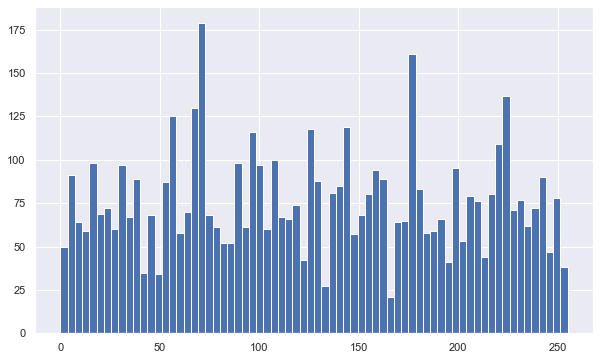

In [17]:
plt.figure(figsize=(10,6))
x = range(len(hog_hist_test3[0]))
y = hog_hist_test3[0]
plt.hist(x, weights=y, bins=70);

# Feature Fusion

In [18]:
test_features3 = np.concatenate((hog_hist_test3, mbhx_hist_test3, mbhy_hist_test3), axis=1)

In [19]:
np.savetxt("test_3_features.csv", test_features3, delimiter=",")

In [20]:
test_features3 = pd.read_csv("test_3_features.csv",header=None)

In [21]:
labels = []
for file in test_set_3_files:
    labels.append(file.split('/')[2].split('-')[0])

In [22]:
test_features3['label']=labels

In [23]:
X_test3 = test_features3.iloc[:,:-1]
y_test3 = test_features3.iloc[:,-1]

y_pred3 = model.predict(X_test3)
print_score(y_test3,y_pred3);

Accuracy : 0.3870967741935484
Precision : 0.34078661034306196
Recall : 0.3870967741935484
F1 Score : 0.33873527905785966
[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 0]]
